In [1]:
import torch
from datasets import IndexedDataset, WeightedDataset
from torch.utils.data import DataLoader, DistributedSampler

from utils import get_args
from architectures import load_architecture

from samplers import DistributedCustomSampler
from losses import trades_loss
from tqdm.notebook import tqdm
from architectures import load_architecture, load_statedict, add_lora

args = get_args()
args.arch = 'LeNet5'
args.dataset = 'MNIST'
args.selection_method = 'random'

# Example Usage

model, target_layers = load_architecture(args)
model.to('cuda')

# statedict = load_statedict(args)
# model.load_state_dict(statedict)
# add_lora(target_layers, model)

args.iterations = 20
args.pruning_ratio = 0
args.delta = 1
args.batch_size = 64
args.pruning_strategy = 'random'
args.batch_strategy = 'random'
args.sample_size= 128

# train_dataset = IndexedDataset()
print('init weighted dataset')
train_dataset = WeightedDataset(args, train=True, prune_ratio = args.pruning_ratio,  )

train_sampler = DistributedCustomSampler(args, train_dataset, num_replicas=2, rank=0, drop_last=True)

print('init dataloder')
trainloader = DataLoader(train_dataset, batch_size=None, sampler = train_sampler,) 

./data
init weighted dataset
60000 60000
init dataloder


In [2]:
from losses import get_loss, get_eval_loss


rank = 'cuda'

optimizer = torch.optim.SGD( model.parameters(),lr=args.init_lr, weight_decay=args.weight_decay, momentum=args.momentum, nesterov=True, )

for iteration in range(args.iterations):

    model.train()
    train_sampler.set_epoch(iteration)

    for batch_id, batch in tqdm(enumerate( trainloader ) ):

        optimizer.zero_grad()

        data, target, idxs = batch

        # print(idxs)

        data, target = data.to(rank), target.to(rank) 
         
        loss_values, clean_values, robust_values, logits_nat, logits_adv = get_loss(args, model, data, target, optimizer)
        # print(logits_adv.shape)
        # print(logits_nat.shape)
        # assert torch.isfinite(loss_values).all(), "Loss contains NaNs!"
        # assert torch.isfinite(logits_nat).all(), "Logits_nat contains NaNs!"
        # assert torch.isfinite(logits_adv).all(), "Logits_adv contains NaNs!"

        # train_dataset.update_scores(iteration, idxs,loss_values)
        train_dataset.update_scores(rank, idxs, clean_values, robust_values, loss_values, logits_nat, logits_adv)

        train_dataset.global_scores2[iteration][idxs] = loss_values.detach().cpu()

        loss = train_dataset.compute_loss(idxs, loss_values)

        loss.backward()
        optimizer.step()

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

pruning
remove tail
process


0it [00:00, ?it/s]

torch.Size([10, 60000])


  0%|          | 0/100 [00:00<?, ?it/s]

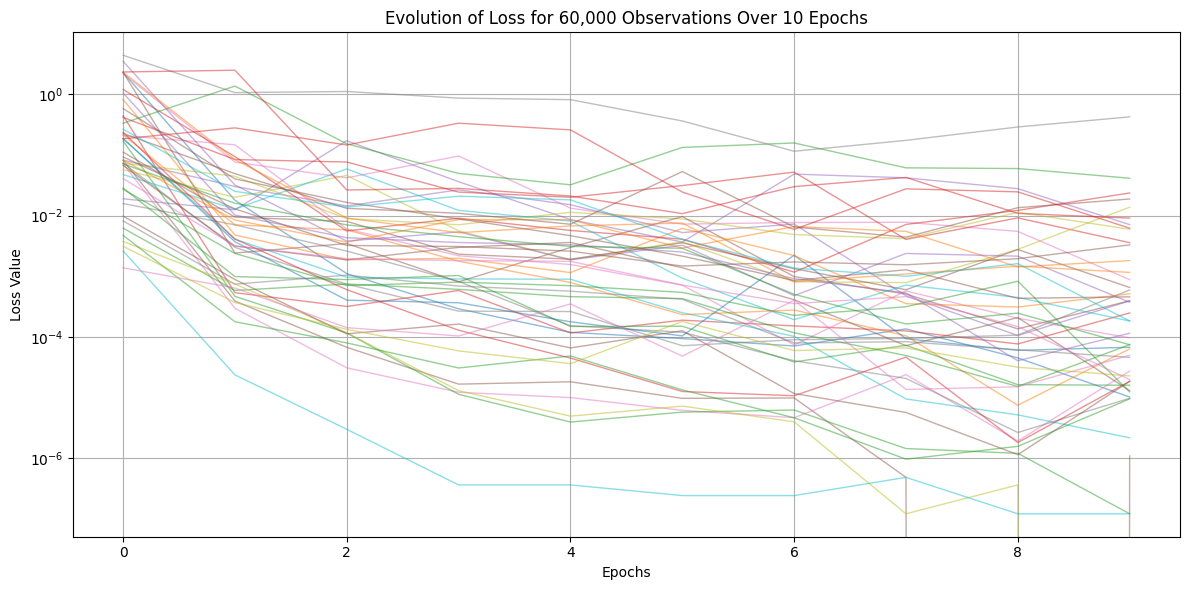

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a sample tensor with dimensions (10, 60000)
# Each of the 10 rows represents an epoch, and each column represents a loss value for one of the 60,000 observations.
np.random.seed(0)  # For reproducibility
tensor = train_dataset.global_scores2 #np.random.rand(10, 60000)  # Simulating loss values

# Sampling 1000 observations from the 60,000
print(tensor.shape)
sample_indices = np.random.choice(tensor.shape[1], size=100, replace=False)

sampled_tensor = tensor[:, sample_indices]

# Plotting the evolution of the loss for the 60,000 observations over 10 epochs
plt.figure(figsize=(12, 6))

# Plotting each observation's loss over the 10 epochs
for i in tqdm(range(sampled_tensor.shape[1])):
    plt.plot(range(10), sampled_tensor[:, i], alpha=0.5, linewidth=1)  # Plotting with low opacity and thin lines for clarity

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.yscale('log')  # Setting y-axis to log scale

plt.title('Evolution of Loss for 60,000 Observations Over 10 Epochs')
plt.grid(True)
plt.tight_layout()

plt.show()


In [3]:
observations_losses = train_dataset.global_scores2.T.numpy()

In [4]:
import numpy as np
from scipy.optimize import curve_fit

# Exponential decay function with fixed a
def exponential_decay_fixed_a(t, b, c, a):
    return a * np.exp(-b * t) + c

# Fit model to data for each observation with a fixed parameter a and c >= 0
def fit_exponential_decay_with_bounds(loss_values):
    t = np.arange(len(loss_values))
    a = loss_values[0]  # Fix a as the first loss value
    if len(loss_values) < 3:  # Minimum data length check
        return None  # Not enough data to fit
    # Use curve_fit with bounds to ensure c >= 0
    popt, _ = curve_fit(
        lambda t, b, c: exponential_decay_fixed_a(t, b, c, a),
        t,
        loss_values,
        p0=(0.1, 0),        # Initial guesses for b and c
        bounds=([0, 0], [np.inf, np.inf])  # Bounds: b >= 0, c >= 0
    )
    return (a, *popt)  # Return a, b, c

# Calculate goodness of fit metrics
def calculate_goodness_of_fit(observed, predicted):
    # R-squared
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # MSE
    mse = np.mean((observed - predicted) ** 2)
    
    # RMSE
    rmse = np.sqrt(mse)
    
    # MAE
    mae = np.mean(np.abs(observed - predicted))
    
    return r_squared, mse, rmse, mae

# Fit models independently for each observation and calculate goodness of fit
global_mse_1 = np.zeros(observations_losses.shape[0])
global_rmse_1 = np.zeros(observations_losses.shape[0])
global_mae_1 = np.zeros(observations_losses.shape[0])
for idx, loss_values in tqdm(enumerate(observations_losses)):
    params = fit_exponential_decay_with_bounds(loss_values)
    if params:
        a, b, c = params
        t = np.arange(len(loss_values))
        predicted = exponential_decay_fixed_a(t, b, c, a)
        mse, rmse, mae = calculate_goodness_of_fit(loss_values, predicted)
        global_mse_1[idx] = mse
        global_rmse_1[idx] = rmse
        global_mae_1[idx] = mae



0it [00:00, ?it/s]

ValueError: array must not contain infs or NaNs

In [36]:
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

# Exponential decay function with fixed a and c = 0
def exponential_decay_fixed_a(t, b, a):
    return a * np.exp(-b * t)

# Fit model to data for each observation with a fixed parameter a and c = 0
def fit_exponential_decay_fixed_c_zero(loss_values):
    t = np.arange(len(loss_values))
    a = loss_values[0]  # Fix a as the first loss value
    if len(loss_values) < 3:  # Minimum data length check
        return None  # Not enough data to fit
    # Use curve_fit to estimate only b with c = 0 fixed
    popt, _ = curve_fit(
        lambda t, b: exponential_decay_fixed_a(t, b, a),
        t,
        loss_values,
        p0=(0.1,),        # Initial guess for b
        #bounds=([0], [np.inf])  # Bounds: b >= 0
    )
    return (a, popt[0])  # Return a and b

# Calculate goodness of fit metrics
def calculate_goodness_of_fit(observed, predicted):
    # R-squared
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # MSE
    mse = np.mean((observed - predicted) ** 2)
    
    # RMSE
    rmse = np.sqrt(mse)
    
    # MAE
    mae = np.mean(np.abs(observed - predicted))
    
    return r_squared, mse, rmse, mae

# # Example loss values for multiple observations
# observations_losses = [
#     [1.0, 0.8, 0.6, 0.5, 0.4],  # Observation 1
#     [0.9, 0.7, 0.65],           # Observation 2
#     [1.1, 0.95, 0.85, 0.8]      # Observation 3
# ]

# Arrays to store goodness of fit metrics for each observation
global_r2 = np.zeros(len(observations_losses))
global_mse = np.zeros(len(observations_losses))
global_rmse = np.zeros(len(observations_losses))
global_mae = np.zeros(len(observations_losses))

# Fit models independently for each observation and calculate goodness of fit
for idx, loss_values in tqdm(enumerate(observations_losses), total=len(observations_losses)):
    params = fit_exponential_decay_fixed_c_zero(loss_values)
    if params:
        a, b = params
        t = np.arange(len(loss_values))
        predicted = exponential_decay_fixed_a(t, b, a)
        r_squared, mse, rmse, mae = calculate_goodness_of_fit(loss_values, predicted)
        global_r2[idx] = r_squared
        global_mse[idx] = mse
        global_rmse[idx] = rmse
        global_mae[idx] = mae

# Display the results
print("R-squared for each observation:", global_r2)
print("MSE for each observation:", global_mse)
print("RMSE for each observation:", global_rmse)
print("MAE for each observation:", global_mae)


  0%|          | 0/60000 [00:00<?, ?it/s]

/home/mheuillet/Desktop/robust_training/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_6009/1519239995.py:30: RuntimeWarning: invalid value encountered in double_scalars
  r_squared = 1 - (ss_res / ss_tot)
100%|██████████| 60000/60000 [00:16<00:00, 3611.96it/s]

R-squared for each observation: [0.91521045        nan 0.99999989 ...        nan 0.9588786         nan]
MSE for each observation: [3.74383398e-02 0.00000000e+00 5.09324338e-08 ... 0.00000000e+00
 1.32522930e-06 0.00000000e+00]
RMSE for each observation: [0.1934899  0.         0.00022568 ... 0.         0.00115119 0.        ]
MAE for each observation: [0.10037836 0.         0.00016283 ... 0.         0.00083805 0.        ]


In [ ]:

# for i in range(len(train_dataset)):
#     print(train_dataset[i])
import numpy as np

def obtain_latent_dataset(model, dataset, batch_size=32):

    # Assuming the dataset is a list or similar iterable with a known length
    num_samples = len(dataset)

    # Assume the dimensionality of the latent representation can be determined from one sample
    image,label, idx = dataset[0]
    image = torch.Tensor(image).to('cuda').unsqueeze(0)
    print(image.shape)
    first_latent_rep = model.get_latent_representation(image)
    latent_dim = first_latent_rep.shape[1]
    print(first_latent_rep.shape)
        
    # Preallocate the array for the latent representations
    latent_dataset = torch.zeros((num_samples, latent_dim))


    for i in tqdm( range(0, num_samples, batch_size) ):
        # Get the current batch of data
        batch_indices = list(range(i, min(i + batch_size, num_samples)))
        images,labels,idxs = dataset[batch_indices]
        images = images.to('cuda')
            
        # Process the batch to get latent representations
        batch_latent_reps = model.get_latent_representation(images) 
            
        # Store the results in the preallocated array
        latent_dataset[i:i + batch_size] = batch_latent_reps.detach().cpu()

    return latent_dataset

features =  obtain_latent_dataset(model,train_dataset,64)
train_dataset.define_latent_features(features)

